# Anomaly Detection on CIFAR-10 with Precomputed Features
This notebook demonstrates saving and loading pre-extracted features for traditional methods.

## 1. Setup and Installation
Install required libraries.

In [1]:
# !pip install torch torchvision scikit-learn matplotlib numpy

## 2. Imports
Import necessary modules and helper functions.

In [3]:
import os
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
from model_utils import CIFAR10Loader, DeepSVDDModel, train_model, evaluate_model
from feature_extractor import create_and_save_feature_extractor, load_feature_extractor

## 3. Configuration
Define hyperparameters and device.

In [4]:
batch_size = 64
epochs = 60
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
os.makedirs('results', exist_ok=True)
print(f'Using device: {device}')

Using device: cuda


## 4. Data Loading
Load CIFAR-10 data and split into normal (ship) and anomaly sets.

In [5]:
data_loader = CIFAR10Loader(batch_size=batch_size)
train_loader, test_normal_loader, test_anomaly_loader = data_loader.get_dataloaders()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## 5. Train Deep SVDD Model
Initialize and train the Deep SVDD model.

In [6]:
deep_model = DeepSVDDModel(device=device)
start = time.time()
losses = train_model(deep_model, train_loader, epochs=epochs, device=device)
print(f'Training time: {time.time() - start:.2f} sec')


Training layer 1
Phase 1, Epoch [5/15], Loss: 49.8409, LR: 0.000750
Phase 1, Epoch [10/15], Loss: 42.2927, LR: 0.000251
Phase 1, Epoch [15/15], Loss: 40.8025, LR: 0.000001

Training layer 2
Phase 2, Epoch [5/15], Loss: 5.3604, LR: 0.000225
Phase 2, Epoch [10/15], Loss: 3.1902, LR: 0.000076
Phase 2, Epoch [15/15], Loss: 2.7862, LR: 0.000001

Training layer 3
Phase 3, Epoch [5/15], Loss: 0.0281, LR: 0.000068
Phase 3, Epoch [10/15], Loss: 0.0178, LR: 0.000023
Phase 3, Epoch [15/15], Loss: 0.0151, LR: 0.000001

Final phase: training all layers
Phase 4, Epoch [5/15], Loss: 0.0049, LR: 0.000021
Phase 4, Epoch [10/15], Loss: 0.0028, LR: 0.000008
Phase 4, Epoch [15/15], Loss: 0.0025, LR: 0.000001
Training time: 214.09 sec


## 6. Plot Training Loss
Visualize training loss.

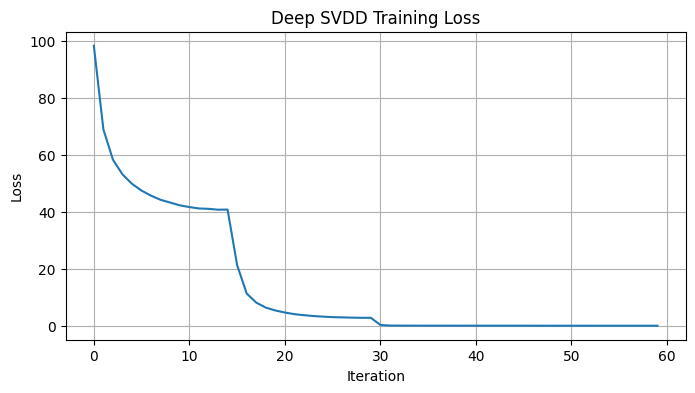

In [7]:
plt.figure(figsize=(8,4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Deep SVDD Training Loss')
plt.grid(True)
plt.show()

## 7. Evaluate Deep SVDD Model
Compute anomaly scores and AUC.

In [8]:
deep_results = evaluate_model(deep_model, test_normal_loader, test_anomaly_loader, device)
print(f"Deep SVDD AUC: {deep_results['auc_score']:.4f}")

Deep SVDD AUC: 0.7845


## 8. Precompute and Save Features
Extract features once and save to disk.

In [9]:
# Create or load the feature extractor
feat_path = 'results/train_feats.npy'
if not os.path.exists(feat_path):
    extractor = create_and_save_feature_extractor(device=device)
    # Extract and save features
    train_feats = extractor.extract_features(train_loader)
    np.save('results/train_feats.npy', train_feats)
    test_norm_feats = extractor.extract_features(test_normal_loader)
    np.save('results/test_norm_feats.npy', test_norm_feats)
    test_anom_feats = extractor.extract_features(test_anomaly_loader)
    np.save('results/test_anom_feats.npy', test_anom_feats)
    print('Features saved to results/')
else:
    print('Features already exist. Skipping extraction.')

Features already exist. Skipping extraction.


## 9. Load Precomputed Features for Traditional Methods
Load features for One-Class SVM and Isolation Forest.

In [10]:
train_feats = np.load('results/train_feats.npy')
test_norm_feats = np.load('results/test_norm_feats.npy')
test_anom_feats = np.load('results/test_anom_feats.npy')
# Standardize
mean = train_feats.mean(axis=0)
std = train_feats.std(axis=0) + 1e-10
train_feats = (train_feats - mean) / std
test_norm_feats = (test_norm_feats - mean) / std
test_anom_feats = (test_anom_feats - mean) / std
print('Features loaded and standardized.')

Features loaded and standardized.


## 10. Train and Evaluate Traditional Methods

In [11]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_curve, auc

# One-Class SVM
ocsvm = OneClassSVM(kernel='rbf', nu=0.1, gamma='scale')
ocsvm.fit(train_feats)
norm_scores_svm = -ocsvm.score_samples(test_norm_feats)
anom_scores_svm = -ocsvm.score_samples(test_anom_feats)
labels = np.concatenate([np.zeros(len(norm_scores_svm)), np.ones(len(anom_scores_svm))])
scores = np.concatenate([norm_scores_svm, anom_scores_svm])
fpr_svm, tpr_svm, _ = roc_curve(labels, scores)
auc_svm = auc(fpr_svm, tpr_svm)
print(f'One-Class SVM AUC: {auc_svm:.4f}')

# Isolation Forest
iforest = IsolationForest(n_estimators=100, contamination=0.1, n_jobs=-1, random_state=42)
iforest.fit(train_feats)
norm_scores_if = -iforest.score_samples(test_norm_feats)
anom_scores_if = -iforest.score_samples(test_anom_feats)
labels_if = labels
scores_if = np.concatenate([norm_scores_if, anom_scores_if])
fpr_if, tpr_if, _ = roc_curve(labels_if, scores_if)
auc_if = auc(fpr_if, tpr_if)
print(f'Isolation Forest AUC: {auc_if:.4f}')

One-Class SVM AUC: 0.6035
Isolation Forest AUC: 0.5939


## 11. ROC Curve Comparison
Plot ROC for all methods.

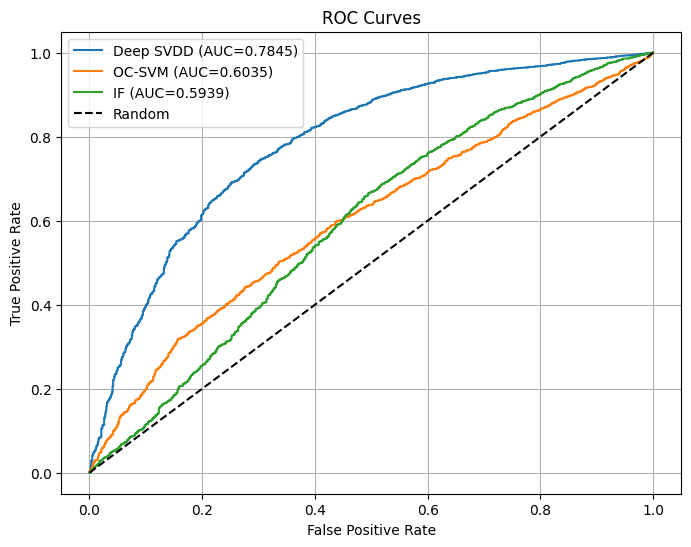

In [12]:
plt.figure(figsize=(8,6))
plt.plot(deep_results['fpr'], deep_results['tpr'], label=f"Deep SVDD (AUC={deep_results['auc_score']:.4f})")
plt.plot(fpr_svm, tpr_svm, label=f"OC-SVM (AUC={auc_svm:.4f})")
plt.plot(fpr_if, tpr_if, label=f"IF (AUC={auc_if:.4f})")
plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()